# PINNs - NVIDIA Modulus Sym - Getting Started

- For installation, refer to the official [Installation Guide for NVIDIA Modulus Sym](https://pypi.org/project/nvidia-modulus.sym/).

- For getting started with Jupyter Notebook, this [Usage Guide](https://docs.nvidia.com/deeplearning/modulus/modulus-sym-v110/notebook.nbconvert.html) explains how to work with NVIDIA Modulus Sym effectively. The "Getting Started Example" in this notebook is based on the linked notebook.

- The introductory content of this Notebook is based on the [NVIDIA Modulus Sym documentation](https://docs.nvidia.com/deeplearning/modulus/modulus-sym/index.html), summarized with the assistance of ChatGPT.

- See [NVIDIA Modulus Sym documentation](https://docs.nvidia.com/deeplearning/modulus/modulus-sym-v110/user_guide/basics/modulus_overview.html) for a concise description of the basic building blocks.

- **Note:** I am using Modulus Sym Version 1.6.0 due to a known [issue with later versions](https://github.com/NVIDIA/modulus-sym/issues/206).

## Introduction

This notebook will guide you through the following steps:

- **Installing and Setting Up NVIDIA Modulus Sym on Kaggle**: Learn how to get started with NVIDIA Modulus Sym quickly and effectively.
- **Running a Getting Started Example**: Use the given example to train and utilize your first Physics-Informed Neural Network (PINN).
- TODO: **Exploring Advanced Examples**: Dive into more complex use cases that require a basic understanding of physics.

Physics-Informed Neural Networks (PINNs) can solve differential equations by integrating physics directly into neural networks. NVIDIA Modulus Sym, a state-of-the-art PINNs framework, excels at handling complex geometries, multi-physics scenarios, and parameterized problems.

### **Key Concepts**

- **Solving Differential Equations**:  
  PINNs minimize a loss function during training to enforce physics constraints and boundary conditions.

- **Monte Carlo Integration**:  
  Modulus Sym leverages Monte Carlo integration to maintain consistent loss scaling and enable adaptive sampling for improved efficiency.

- **Parameterized Geometries**:  
  By treating parameters as inputs, Modulus Sym can solve multiple configurations simultaneously, significantly reducing computational costs.

- **Weak Solutions**:  
  The framework supports weak PDE solutions, effectively addressing interface problems and Neumann boundary conditions.

### **Why Choose Modulus Sym?**

- Efficient and scalable loss integration.
- Flexibility for solving parameterized and variational problems.
- Robust support for multi-physics and intricate geometries.

These features make Modulus Sym an excellent choice for data scientists tackling physics-driven challenges with machine learning.

In [1]:
!pip install "pint==0.19.2"
!pip install nvidia-modulus
!pip install nvidia-modulus-sym==1.6.0 --no-build-isolation
!pip install torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pint: filename=pint-0.19.2-py3-none-any.whl size=230991 sha256=52c88a66a9ce0ef762f28098828520b78758bc74f77835e5862425cb69548631
  Stored in directory: /root/.cache/pip/wheels/eb/00/87/c216aa83b91597845d9fec6fcd9dbe31c945a25d968dd4765a
Successfully built pint
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.8/548.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 90.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 7.2 MB/s eta 0:0

In [2]:
from sympy import Symbol, Function, Eq, diff, exp
import os
import warnings
import numpy as np

import modulus.sym
from modulus.sym.hydra import instantiate_arch, ModulusConfig
from modulus.sym.hydra.utils import compose
from modulus.sym.solver import Solver
from modulus.sym.domain import Domain
from modulus.sym.geometry.primitives_2d import Rectangle
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
from modulus.sym.domain.inferencer import PointwiseInferencer
from modulus.sym.key import Key
from modulus.sym.node import Node
from modulus.sym.eq.pde import PDE
import sympy as sp
import torch

warnings.filterwarnings("ignore")

## Getting Started Example

### Considered Differential Equation

$$
\quad \frac{\partial^2 u(x)}{\partial x^2} - f = 0
$$

with the boundary conditions:

$$
u(0) = 0 \quad \text{and} \quad u(1) = 0
$$

where
- $u(x)$, is the function to solve for, representing the solution of the PDE,
- $x$, is the spatial variable over the domain $[0, 1]$,
- $f = 1$, a constant forcing term in the equation.


This setup describes a second-order differential equation with constant source $f = 1$, subject to fixed boundary conditions, often encountered in problems like heat conduction or steady-state diffusion.

In [3]:
# Updated configuration with deeper network and more steps
config_content = """
defaults:
  - modulus_default
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

scheduler:
  decay_rate: 0.95
  decay_steps: 500

save_filetypes: "vtk,npz"

training:
  rec_results_freq: 1000
  rec_constraint_freq: 1000
  max_steps: 50000

batch_size:
  interior: 1024
  pec: 512
  ic: 1024

arch:
  fully_connected:
    arch_type: "fully_connected"
    layer_size: 256
    nr_layers: 16
    skip_connections: True
    activation_fn: "silu"

hydra:
  run:
    dir: ./outputs/${now:%Y-%m-%d}/${now:%H-%M-%S}
"""

config_file = "config_fdtd.yaml"
with open(config_file, "w") as file:
    file.write(config_content)
print(f"{config_file} file created successfully!")

config_fdtd.yaml file created successfully!


In [4]:
# Load config.yaml
from modulus.sym.hydra.utils import compose
cfg = compose(config_path=".", config_name="config_fdtd")
cfg.network_dir = 'outputs'

In [5]:
# # Define geometry
# width, height = 2.0, 2.0
# rec = Rectangle((-width / 2, -height / 2), (width / 2, height / 2))

In [6]:
from sympy import Or
import sympy as sp

# Define symbolic variables
# Define symbolic variables
x, y, t = sp.Symbol("x"), sp.Symbol("y"), sp.Symbol("t")
width, height = 2.0, 2.0
rec = Rectangle((-width / 2, -height / 2), (width / 2, height / 2))

In [7]:
class MaxwellPDE(PDE):
    def __init__(self):
        input_variables = {"x": x, "y": y, "t": t}
        Ez = Function("Ez")(*input_variables)
        Hx = Function("Hx")(*input_variables)
        Hy = Function("Hy")(*input_variables)

        mu0 = 4 * np.pi * 1e-7
        epsilon0 = 8.854187817e-12

        maxwell_eq1 = diff(Ez, t) - (1 / epsilon0) * (diff(Hy, x) - diff(Hx, y))
        maxwell_eq2 = diff(Hx, t) + (1 / mu0) * diff(Ez, y)
        maxwell_eq3 = diff(Hy, t) - (1 / mu0) * diff(Ez, x)

        self.equations = {
            "Maxwell_Ez": maxwell_eq1,
            "Maxwell_Hx": maxwell_eq2,
            "Maxwell_Hy": maxwell_eq3,
        }

In [8]:
# Define the PDE
eq = MaxwellPDE()

In [9]:
# # Define the neural network
# input_keys = [Key("x"), Key("y"), Key("t")]
# output_keys = [Key("Ez"), Key("Hx"), Key("Hy")]
# wave_net = instantiate_arch(
#     input_keys=input_keys,
#     output_keys=output_keys,
#     cfg=cfg.arch.fully_connected,  # Use the fully_connected config
# )

In [10]:
# # Nodes for the solver
# nodes = (
#     [wave_net.make_node(name="wave_network")]
#     + [Node.from_sympy(eq.equations["Maxwell_Ez"], "Maxwell_Ez")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hx"], "Maxwell_Hx")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hy"], "Maxwell_Hy")]
# )

In [11]:
# # Make domain
# domain = Domain()

In [12]:
from sympy import Or

# Define symbolic variables
# Define symbolic variables
x, y, t = sp.Symbol("x"), sp.Symbol("y"), sp.Symbol("t")


In [13]:
!pip uninstall timm -y
!pip install timm
!pip uninstall -y pillow
!pip install pillow==9.5.0

# !pip uninstall torch torchvision torchaudio -y
# !pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html


Found existing installation: timm 1.0.12
Uninstalling timm-1.0.12:
  Successfully uninstalled timm-1.0.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.0 MB/s eta 0:00:00:00:01
Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.5 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 0.3.0 requires pillow<12.0.0,>=10.0.0, but you have pillow 9.5.0 which is incompatible.
nvidia-modulus-sym 1.6.0 requires pillow==10.2.0, but you have pillow 9.5.0 which is incompatible.


In [14]:
# input_keys = [Key("x"), Key("y"), Key("t")]
# output_keys = [Key("Ez"), Key("Hx"), Key("Hy")]
# wave_net = instantiate_arch(
#     input_keys=input_keys,
#     output_keys=output_keys,
#     cfg=cfg.arch.fully_connected,
# )

# nodes = (
#     [wave_net.make_node(name="wave_network")]
#     + [Node.from_sympy(eq.equations["Maxwell_Ez"], "Maxwell_Ez")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hx"], "Maxwell_Hx")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hy"], "Maxwell_Hy")]
# )

# # Cell 3: Define Domain and Constraints
# domain = Domain()

# pec = PointwiseBoundaryConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={"Ez": 0.0},
#     batch_size=cfg.batch_size.pec,
#     criteria=sp.Or(sp.Eq(y, -height / 2), sp.Eq(y, height / 2)),
#     lambda_weighting={"Ez": 100.0},
#     parameterization={t: (0.0, 1e-9)},
# )
# domain.add_constraint(pec, "PEC")

# ic = PointwiseInteriorConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={
#         "Ez": sp.exp(-((x - 0.0) ** 2 + (y - 0.0) ** 2) / 1e-4),
#         "Hx": 0.0,
#         "Hy": 0.0
#     },
#     batch_size=cfg.batch_size.ic,
#     bounds={x: (-width / 2, width / 2), y: (-height / 2, height / 2)},
#     parameterization={t: (0.0, 0.0)},
#     lambda_weighting={"Ez": 100.0, "Hx": 100.0, "Hy": 100.0},
# )
# domain.add_constraint(ic, "InitialCondition")

# interior = PointwiseInteriorConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={"Maxwell_Ez": 0.0, "Maxwell_Hx": 0.0, "Maxwell_Hy": 0.0},
#     batch_size=cfg.batch_size.interior,
#     bounds={x: (-width / 2, width / 2), y: (-height / 2, height / 2), t: (0, 1e-9)},
#     lambda_weighting={"Maxwell_Ez": 1.0, "Maxwell_Hx": 1.0, "Maxwell_Hy": 1.0},
#     parameterization={t: (0.0, 1e-9)},
# )
# domain.add_constraint(interior, "Interior")

# # PointwiseInferencer with corrected input shape
# x_inf = np.linspace(-width/2, width/2, 128)
# y_inf = np.linspace(-height/2, height/2, 128)
# t_inf = np.linspace(0, 1e-9, 20)
# X, Y, T = np.meshgrid(x_inf, y_inf, t_inf)
# invar_numpy = {
#     "x": X.flatten().astype(np.float32),
#     "y": Y.flatten().astype(np.float32),
#     "t": T.flatten().astype(np.float32),
# }
# inferencer = PointwiseInferencer(
#     nodes=nodes,
#     invar=invar_numpy,
#     output_names=["Ez", "Hx", "Hy"],
#     batch_size=1024,
# )
# domain.add_inferencer(inferencer, "Inferencer")

In [15]:
import sympy as sp
import torch
from modulus.sym.domain.inferencer import VoxelInferencer
# Define the neural network
# Define the neural network
# Define the neural network with output scaling
# Define network with corrected scale tuple
# Cell 3: Define Domain and Constraints (Modified)
input_keys = [Key("x"), Key("y"), Key("t")]
output_keys = [Key("Ez"), Key("Hx"), Key("Hy")]
wave_net = instantiate_arch(
    input_keys=input_keys,
    output_keys=output_keys,
    cfg=cfg.arch.fully_connected,
)

nodes = (
    [wave_net.make_node(name="wave_network")]
    + [Node.from_sympy(eq.equations["Maxwell_Ez"], "Maxwell_Ez")]
    + [Node.from_sympy(eq.equations["Maxwell_Hx"], "Maxwell_Hx")]
    + [Node.from_sympy(eq.equations["Maxwell_Hy"], "Maxwell_Hy")]
)

# Cell 3: Define Domain and Constraints
domain = Domain()

pec = PointwiseBoundaryConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"Ez": 0.0},
    batch_size=cfg.batch_size.pec,
    criteria=sp.Or(sp.Eq(y, -height / 2), sp.Eq(y, height / 2)),
    lambda_weighting={"Ez": 100.0},
    parameterization={t: (0.0, 1e-9)},
)
domain.add_constraint(pec, "PEC")

ic = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={
        "Ez": sp.exp(-((x - 0.0) ** 2 + (y - 0.0) ** 2) / 1e-4),
        "Hx": 0.0,
        "Hy": 0.0
    },
    batch_size=cfg.batch_size.ic,
    bounds={x: (-width / 2, width / 2), y: (-height / 2, height / 2)},
    parameterization={t: (0.0, 0.0)},
    lambda_weighting={"Ez": 100.0, "Hx": 100.0, "Hy": 100.0},
)
domain.add_constraint(ic, "InitialCondition")

interior = PointwiseInteriorConstraint(
    nodes=nodes,
    geometry=rec,
    outvar={"Maxwell_Ez": 0.0, "Maxwell_Hx": 0.0, "Maxwell_Hy": 0.0},
    batch_size=cfg.batch_size.interior,
    bounds={x: (-width / 2, width / 2), y: (-height / 2, height / 2), t: (0, 1e-9)},
    lambda_weighting={"Maxwell_Ez": 1.0, "Maxwell_Hx": 1.0, "Maxwell_Hy": 1.0},
    parameterization={t: (0.0, 1e-9)},
)
domain.add_constraint(interior, "Interior")

# CORRECTED: Create time-specific inferencers using PointwiseInferencer with fixed time values
# Create a list of time points to visualize
time_points = np.linspace(0, 1e-9, 10)  # 10 time snapshots

# For each time point, create a 2D grid of points with the fixed time value
for i, t_val in enumerate(time_points):
    # Create a 2D grid for x and y
    x_inf = np.linspace(-width/2, width/2, 128)
    y_inf = np.linspace(-height/2, height/2, 128)
    X, Y = np.meshgrid(x_inf, y_inf)
    
    # Create input variables with fixed time
    invar_numpy = {
        "x": X.flatten().astype(np.float32),
        "y": Y.flatten().astype(np.float32),
        "t": np.full_like(X.flatten(), t_val, dtype=np.float32)
    }
    
#     # Create a PointwiseInferencer for this time point
#     inferencer = PointwiseInferencer(
#         nodes=nodes,
#         invar=invar_numpy,
#         output_names=["Ez", "Hx", "Hy"],
#         batch_size=1024
#     )
#     domain.add_inferencer(inferencer, f"Inferencer_t{i}")

# # Alternatively, we can also add a full 3D inferencer with fewer points in each dimension for visualization
# x_inf = np.linspace(-width/2, width/2, 64)  # Reduced resolution
# y_inf = np.linspace(-height/2, height/2, 64)  # Reduced resolution
# t_inf = np.linspace(0, 1e-9, 10)  # 10 time points
# X, Y, T = np.meshgrid(x_inf, y_inf, t_inf)

# # Create full 3D invar
# invar_numpy_3d = {
#     "x": X.flatten().astype(np.float32),
#     "y": Y.flatten().astype(np.float32),
#     "t": T.flatten().astype(np.float32),
# }

# # Add 3D inferencer (optional, can be commented out if memory is an issue)
# inferencer_3d = PointwiseInferencer(
#     nodes=nodes,
#     invar=invar_numpy_3d,
#     output_names=["Ez", "Hx", "Hy"],
#     batch_size=1024,
# )
# domain.add_inferencer(inferencer_3d, "Inferencer_3D")

In [16]:
# To make the logging work in the jupyter cells. Execute this cell only once
import logging
logging.getLogger().addHandler(logging.StreamHandler())

In [17]:
# Make solver
slv = Solver(cfg, domain)

In [18]:
# Start solver
slv.solve()

Installed PyTorch version 2.4.1+cu121 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
attempting to restore from: /kaggle/working/outputs
optimizer checkpoint not found
model wave_network.0.pth not found
[step:          0] record constraint batch time:  7.292e-02s
[step:          0] saved checkpoint to /kaggle/working/outputs
[step:          0] loss:  9.701e+07
Attempting cuda graph building, this may take a bit...
[step:        100] loss:  7.304e+05, time/iteration:  1.348e+02 ms
[step:        200] loss:  2.738e+04, time/iteration:  2.686e+01 ms
[step:        300] loss:  2.064e+04, time/iteration:  2.698e+01 ms
[step:        400] loss:  1.391e+04, time/iteration:  2.678e+01 ms
[step:        500] loss:  1.196e+04, time/iteration:  2.683e+01 ms
[step:        600] loss:  9.340e+03, time/iteration:  2.680e+01 ms
[step:        700] loss:  8.199e+03, time/iteration:  2.691e+01 ms
[step:        800] loss:  7.841e+03, time/iteration:  2.677e+01 ms
[st

In [19]:
import torch
print(torch.cuda.is_available())

True


In [20]:
# Load the trained model weights
model_path = "/kaggle/working/outputs/wave_network.0.pth"
wave_net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [21]:
wave_net.eval()

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=3, out_features=256, bias=True)
      )
      (1-15): 15 x FCLayer(
        (linear): WeightNormLinear(in_features=256, out_features=256, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=256, out_features=3, bias=True)
    )
  )
)

In [22]:
# import torch
# import numpy as np

# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move the model to the correct device
# wave_net.to(device)

# # Define input data (e.g., grid coordinates and time steps)
# x = np.linspace(-1.0, 1.0, 100)
# y = np.linspace(-1.0, 1.0, 100)
# t = np.linspace(0, 1e-9, 100)
# X, Y, T = np.meshgrid(x, y, t, indexing="ij")

# inputs = {
#     "x": torch.tensor(X.reshape(-1, 1), dtype=torch.float32).to(device),
#     "y": torch.tensor(Y.reshape(-1, 1), dtype=torch.float32).to(device),
#     "t": torch.tensor(T.reshape(-1, 1), dtype=torch.float32).to(device),
# }

# # Predict fields
# with torch.no_grad():
#     outputs = wave_net(inputs)

# # Reshape outputs to 3D arrays
# Ez = outputs["Ez"].reshape(100, 100, 100)
# Hx = outputs["Hx"].reshape(100, 100, 100)
# Hy = outputs["Hy"].reshape(100, 100, 100)

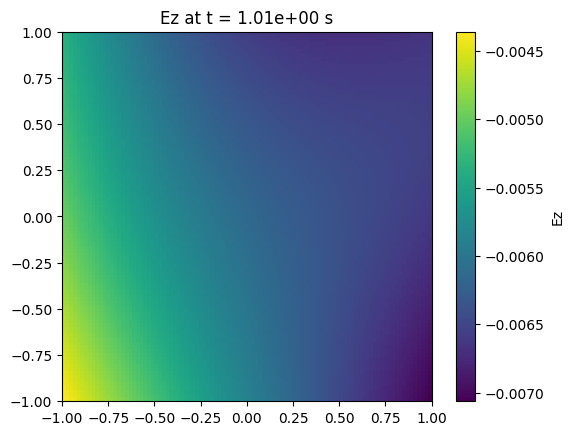

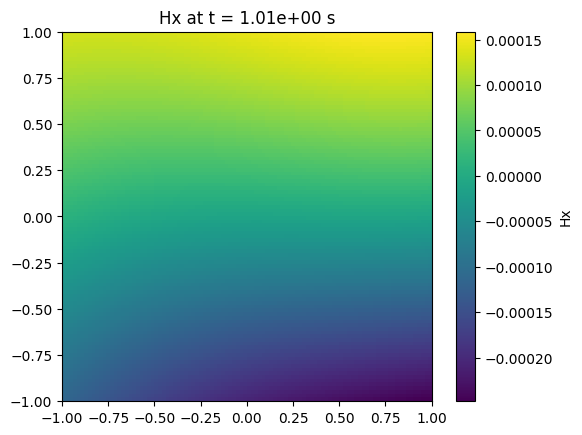

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the correct device
wave_net.to(device)

# Define input data (e.g., grid coordinates and time steps)
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
t = np.linspace(0, 20e-1, 100)
X, Y, T = np.meshgrid(x, y, t, indexing="ij")

# Prepare input dictionary and move to the correct device
inputs = {
    "x": torch.tensor(X.reshape(-1, 1), dtype=torch.float32).to(device),
    "y": torch.tensor(Y.reshape(-1, 1), dtype=torch.float32).to(device),
    "t": torch.tensor(T.reshape(-1, 1), dtype=torch.float32).to(device),
}

# Predict fields
with torch.no_grad():
    outputs = wave_net(inputs)

# Move outputs back to CPU and reshape
Ez = outputs["Ez"].cpu().reshape(100, 100, 100)
Hx = outputs["Hx"].cpu().reshape(100, 100, 100)
Hy = outputs["Hy"].cpu().reshape(100, 100, 100)

# Plot Ez at a specific time step
time_step = 50
Ez_cpu = Ez[:, :, time_step].numpy()  # Ensure it's a NumPy array
plt.imshow(Ez_cpu, cmap="viridis", extent=[-1.0, 1.0, -1.0, 1.0])
plt.colorbar(label="Ez")
plt.title(f"Ez at t = {t[time_step]:.2e} s")
plt.show()

# Plot Hx at a specific time step
time_step = 50
Hx_cpu = Hx[:, :, time_step].numpy()  # Ensure it's a NumPy array
plt.imshow(Hx_cpu, cmap="viridis", extent=[-1.0, 1.0, -1.0, 1.0])
plt.colorbar(label="Hx")
plt.title(f"Hx at t = {t[time_step]:.2e} s")
plt.show()

In [24]:
cfg.run_mode = "eval"
slv.eval()

Success loading model: /kaggle/working/outputs/wave_network.0.pth


In [25]:
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# Constants from MATLAB
mu0 = 4 * np.pi * 1e-7
c0 = 2.997925e8
epsilon0 = 1.0 / (mu0 * c0**2)

# MATLAB model parameters
NX, NY = 200, 200  # Grid size
dx, dy = 0.001, 0.001  # Spatial step [m]
domain_width = NX * dx  # 0.2 m
domain_height = NY * dy  # 0.2 m
dt = 1 / (c0 * np.sqrt(1.0 / dx**2 + 1.0 / dy**2))  # CFL condition
total_time = 415 * dt  # Total simulation time [s]

# Source and monitor locations
Sx, Sy = 50 * dx, 50 * dy  # Source at (0.05, 0.05) m
Ox, Oy = 100 * dx, 150 * dy  # Monitor at (0.1, 0.15) m

# Time points (matching MATLAB's Iter+1 = 416)
time_points = np.linspace(0, total_time, 416)

# Load the trained model weights (assuming wave_net is already defined)
model_path = "/kaggle/working/outputs/wave_network.0.pth"
wave_net.load_state_dict(torch.load(model_path))
wave_net.eval()  # Set to evaluation mode

# Determine the device of the model
device = next(wave_net.parameters()).device  # Get device from model parameters (e.g., 'cuda:0' or 'cpu')
print(f"Model is on device: {device}")

# Prepare input tensors (monitor point over time)
x_tensor = torch.full((len(time_points),), Ox, dtype=torch.float32)
y_tensor = torch.full((len(time_points),), Oy, dtype=torch.float32)
t_tensor = torch.tensor(time_points, dtype=torch.float32)

# Format inputs as a dictionary and move to the same device as the model
inputs_dict = {
    "x": x_tensor.unsqueeze(-1).to(device),  # Shape: [416, 1], moved to device
    "y": y_tensor.unsqueeze(-1).to(device),  # Shape: [416, 1], moved to device
    "t": t_tensor.unsqueeze(-1).to(device),  # Shape: [416, 1], moved to device
}

# Generate predictions
with torch.no_grad():
    predictions = wave_net(inputs_dict)  # Output: dict with keys "Ez", "Hx", "Hy"

# Extract field components from the prediction dictionary and move to CPU for plotting
Ez_pred = predictions["Ez"].cpu().numpy().flatten()  # Shape: [416]
Hx_pred = predictions["Hx"].cpu().numpy().flatten()  # Shape: [416]
Hy_pred = predictions["Hy"].cpu().numpy().flatten()  # Shape: [416]

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir="./runs/maxwell_pinn_output")

# Log predictions to TensorBoard
for i, t in enumerate(time_points):
    writer.add_scalar("Ez_at_monitor", Ez_pred[i], i)
    writer.add_scalar("Hx_at_monitor", Hx_pred[i], i)
    writer.add_scalar("Hy_at_monitor", Hy_pred[i], i)

# Log the entire time series as a plot
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(time_points * 1e9, Ez_pred, label="Ez at (0.1, 0.15) m")
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Ez (V/m)")
ax1.grid(True)
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(time_points * 1e9, Hx_pred, label="Hx at (0.1, 0.15) m")
ax2.set_xlabel("Time (ns)")
ax2.set_ylabel("Hx (A/m)")
ax2.grid(True)
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(time_points * 1e9, Hy_pred, label="Hy at (0.1, 0.15) m")
ax3.set_xlabel("Time (ns)")
ax3.set_ylabel("Hy (A/m)")
ax3.grid(True)
ax3.legend()

plt.tight_layout()
writer.add_figure("Field Time Series", fig, global_step=0)

# Close the writer
writer.close()

print("TensorBoard logs saved to './runs/maxwell_pinn_output'. Run 'tensorboard --logdir ./runs' to visualize.")

Model is on device: cuda:0
TensorBoard logs saved to './runs/maxwell_pinn_output'. Run 'tensorboard --logdir ./runs' to visualize.


In [26]:
tensorboard --logdir ./kaggle/working/outputs/events.out.tfevents.1740754679.9dc92993a511.40.0

SyntaxError: invalid decimal literal (<ipython-input-26-2c7297ff7f82>, line 1)

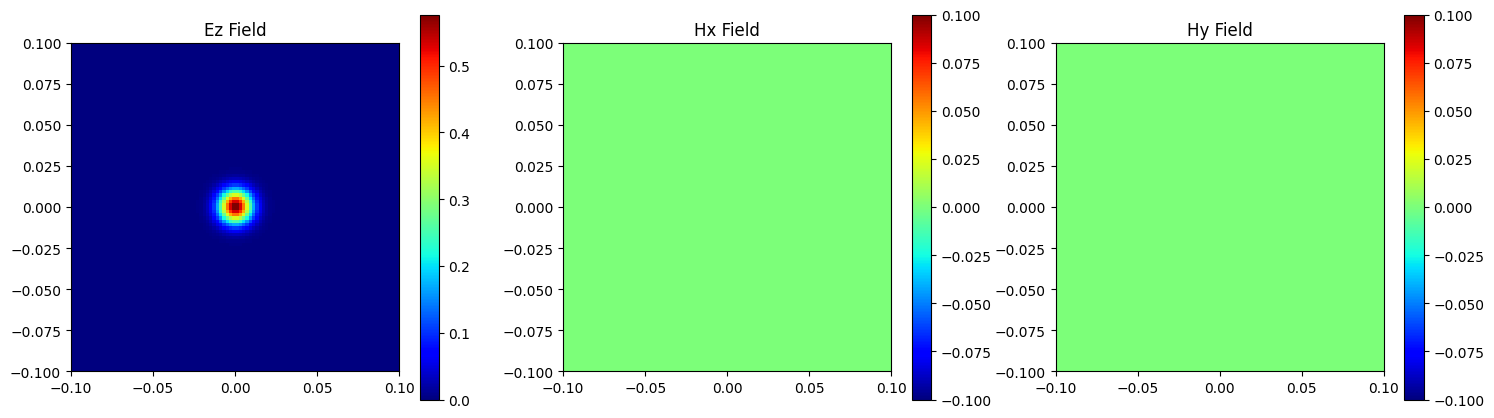

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid parameters
NX, NY = 100, 100  # Domain size in X and Y
T = 1000  # Number of time steps
dx, dy = 0.002, 0.002  # Spatial step
dt = 1e-12  # Time step
x_vals = np.linspace(-0.1, 0.1, NX)  # X-axis range
y_vals = np.linspace(-0.1, 0.1, NY)  # Y-axis range
t_vals = np.linspace(0, 1e-9, T)  # Time range

# Generate mesh grid of points
X, Y, T_grid = np.meshgrid(x_vals, y_vals, t_vals, indexing="ij")

# Flatten for model input
x_input = X.flatten()
y_input = Y.flatten()
t_input = T_grid.flatten()

# Predict fields
with torch.no_grad():
    outputs = wave_net(inputs)

# Move outputs back to CPU and reshape
Ez = outputs["Ez"].cpu().reshape(100, 100, 100)
Hx = outputs["Hx"].cpu().reshape(100, 100, 100)
Hy = outputs["Hy"].cpu().reshape(100, 100, 100)

# Placeholder: Simulated wave_net output (Replace with actual model output)
Ez_output = np.exp(-((x_input**2 + y_input**2) / 1e-4)) * np.sin(2 * np.pi * 1e9 * t_input)
Hx_output = np.zeros_like(Ez_output)  # Assuming zero Hx for now
Hy_output = np.zeros_like(Ez_output)  # Assuming zero Hy for now

# Reshape outputs for visualization
Ez_grid = Ez_output.reshape(NX, NY, T)
Hx_grid = Hx_output.reshape(NX, NY, T)
Hy_grid = Hy_output.reshape(NX, NY, T)

# Select a specific time snapshot for visualization
time_index =100

# Plot the fields
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cmap = "jet"

# Ez field
im1 = axes[0].imshow(Ez_grid[:, :, time_index], extent=[-0.1, 0.1, -0.1, 0.1], cmap=cmap)
axes[0].set_title("Ez Field")
fig.colorbar(im1, ax=axes[0])

# Hx field
im2 = axes[1].imshow(Hx_grid[:, :, time_index], extent=[-0.1, 0.1, -0.1, 0.1], cmap=cmap)
axes[1].set_title("Hx Field")
fig.colorbar(im2, ax=axes[1])

# Hy field
im3 = axes[2].imshow(Hy_grid[:, :, time_index], extent=[-0.1, 0.1, -0.1, 0.1], cmap=cmap)
axes[2].set_title("Hy Field")
fig.colorbar(im3, ax=axes[2])

plt.show()


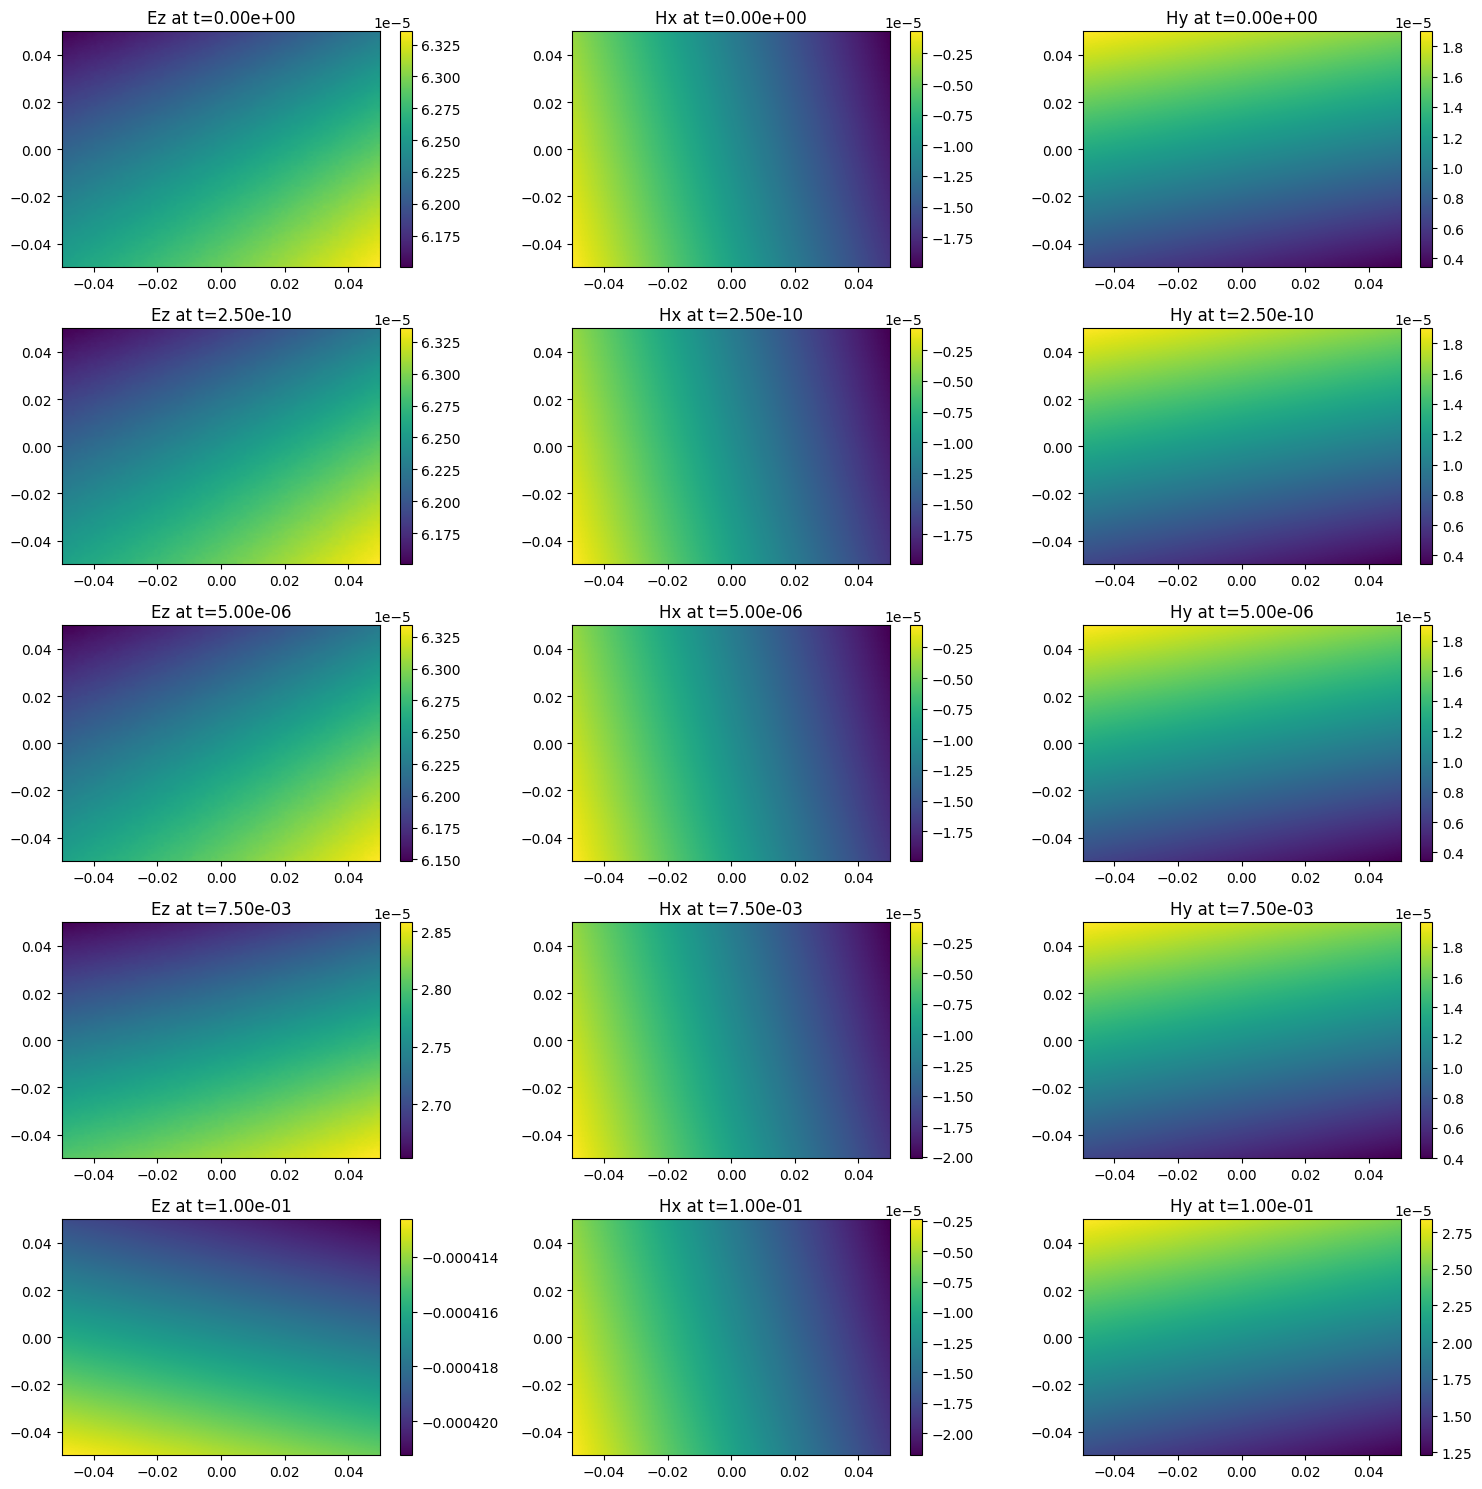

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

width = 0.1  # Define domain width (adjust as needed)
height = 0.1  # Define domain height (adjust as needed)

# Define spatial and temporal domain
x_values = np.linspace(-width / 2, width / 2, 100)
y_values = np.linspace(-height / 2, height / 2, 100)
t_values = [0, 0.25e-9, 0.5e-5, 0.75e-2, 1e-1]  # Time snapshots

x_grid, y_grid = np.meshgrid(x_values, y_values)
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Convert inputs to PyTorch tensors and move them to the selected device
x_tensor = torch.tensor(x_flat, dtype=torch.float32, device=device).unsqueeze(1)
y_tensor = torch.tensor(y_flat, dtype=torch.float32, device=device).unsqueeze(1)

# Move the model to the same device
wave_net = wave_net.to(device)

# Iterate over time steps and visualize results
fig, axs = plt.subplots(len(t_values), 3, figsize=(15, 3 * len(t_values)))

for i, t in enumerate(t_values):
    # Ensure time tensor is on the same device
    t_tensor = torch.full_like(x_tensor, t, device=device)

    # Prepare model input
    inputs = {"x": x_tensor, "y": y_tensor, "t": t_tensor}

    # Run model prediction
    outputs = wave_net(inputs)

    # Move outputs to CPU before converting to NumPy
    Ez_flat = outputs['Ez'].detach().cpu().numpy()
    Hx_flat = outputs['Hx'].detach().cpu().numpy()
    Hy_flat = outputs['Hy'].detach().cpu().numpy()

    # Reshape to grid
    Ez_grid = Ez_flat.reshape(x_grid.shape)
    Hx_grid = Hx_flat.reshape(x_grid.shape)
    Hy_grid = Hy_flat.reshape(x_grid.shape)

    # Plot Ez
    im0 = axs[i, 0].imshow(Ez_grid, extent=[-width / 2, width / 2, -height / 2, height / 2], origin='lower', aspect='auto')
    axs[i, 0].set_title(f'Ez at t={t:.2e}')
    fig.colorbar(im0, ax=axs[i, 0])

    # Plot Hx
    im1 = axs[i, 1].imshow(Hx_grid, extent=[-width / 2, width / 2, -height / 2, height / 2], origin='lower', aspect='auto')
    axs[i, 1].set_title(f'Hx at t={t:.2e}')
    fig.colorbar(im1, ax=axs[i, 1])

    # Plot Hy
    im2 = axs[i, 2].imshow(Hy_grid, extent=[-width / 2, width / 2, -height / 2, height / 2], origin='lower', aspect='auto')
    axs[i, 2].set_title(f'Hy at t={t:.2e}')
    fig.colorbar(im2, ax=axs[i, 2])

plt.tight_layout()
plt.show()


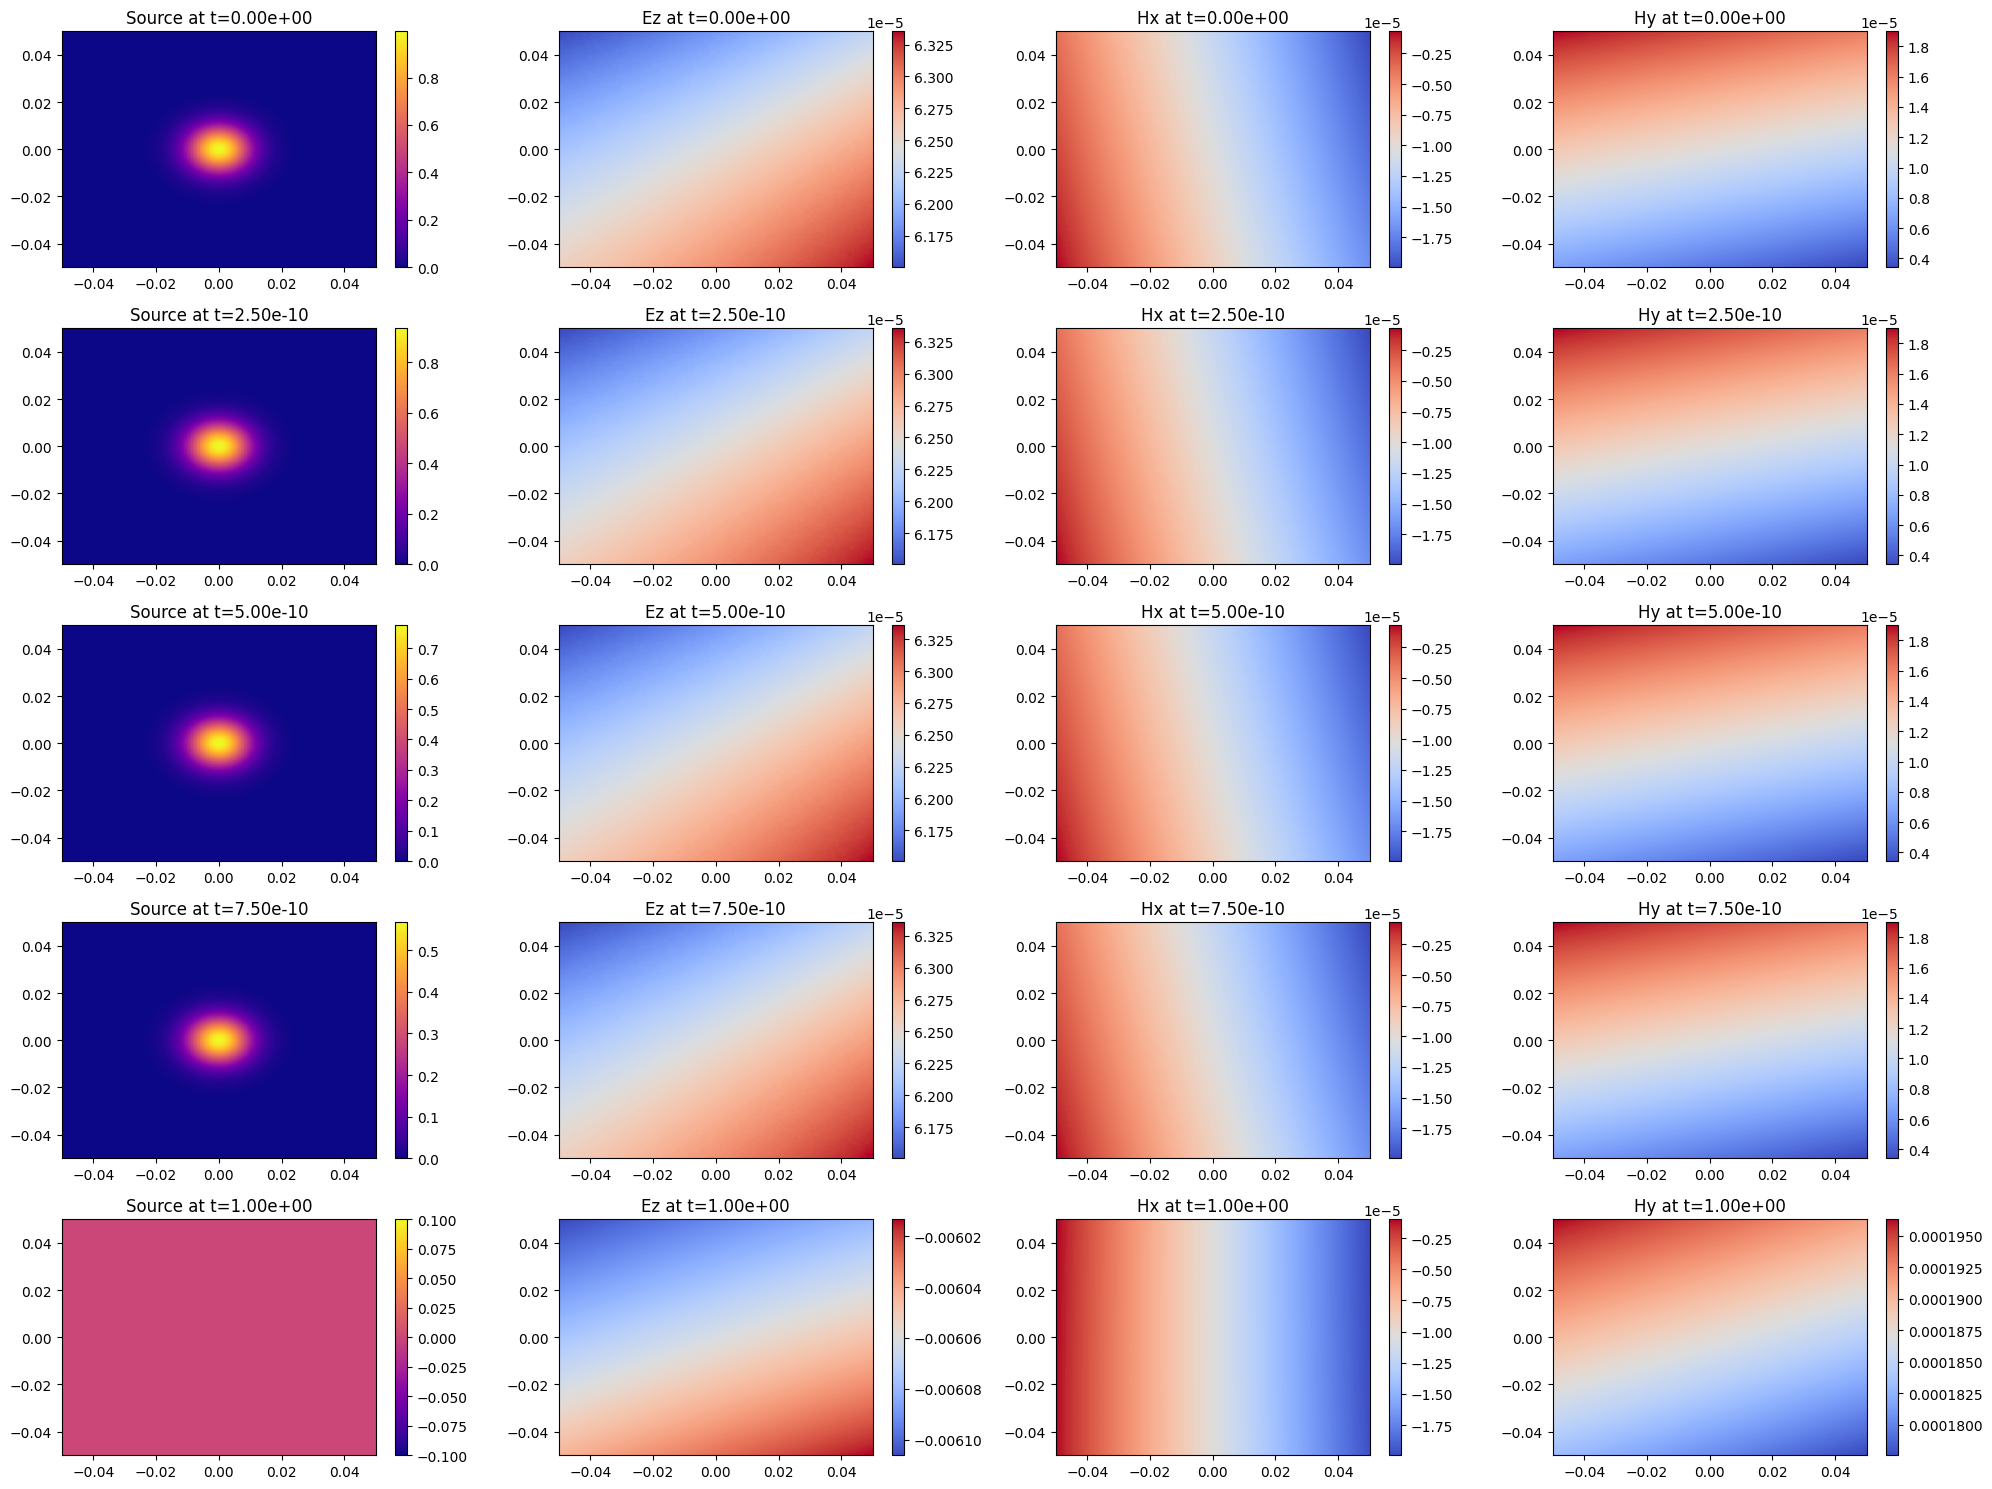

In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

width = 0.1  # Define domain width
height = 0.1  # Define domain height

# Define spatial and temporal domain
x_values = np.linspace(-width / 2, width / 2, 100)
y_values = np.linspace(-height / 2, height / 2, 100)
t_values = [0, 0.25e-9, 0.5e-9, 0.75e-9, 1]  # Time snapshots

x_grid, y_grid = np.meshgrid(x_values, y_values)
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Convert inputs to PyTorch tensors and move them to the selected device
x_tensor = torch.tensor(x_flat, dtype=torch.float32, device=device).unsqueeze(1)
y_tensor = torch.tensor(y_flat, dtype=torch.float32, device=device).unsqueeze(1)

# Define source term: Gaussian pulse centered at (0,0) in space and at t=0
def source_function(x, y, t):
    return torch.exp(-((x ** 2 + y ** 2) / (1e-4)) - (t ** 2 / (1e-18)))

# Move the model to the same device
wave_net = wave_net.to(device)

# Iterate over time steps and visualize results
fig, axs = plt.subplots(len(t_values), 4, figsize=(20, 3 * len(t_values)))  # 4 columns to include source

for i, t in enumerate(t_values):
    # Ensure time tensor is on the same device
    t_tensor = torch.full_like(x_tensor, t, device=device)

    # Compute source values
    source_values = source_function(x_tensor, y_tensor, t_tensor)

    # Prepare model input
    inputs = {"x": x_tensor, "y": y_tensor, "t": t_tensor, "source": source_values}

    # Run model prediction
    outputs = wave_net(inputs)

    # Move outputs to CPU before converting to NumPy
    Ez_flat = outputs['Ez'].detach().cpu().numpy()
    Hx_flat = outputs['Hx'].detach().cpu().numpy()
    Hy_flat = outputs['Hy'].detach().cpu().numpy()
    source_flat = source_values.detach().cpu().numpy()  # Convert source to NumPy

    # Reshape to grid
    Ez_grid = Ez_flat.reshape(x_grid.shape)
    Hx_grid = Hx_flat.reshape(x_grid.shape)
    Hy_grid = Hy_flat.reshape(x_grid.shape)
    source_grid = source_flat.reshape(x_grid.shape)

    # Plot Source
    im_source = axs[i, 0].imshow(source_grid, extent=[-width / 2, width / 2, -height / 2, height / 2], origin='lower', aspect='auto', cmap='plasma')
    axs[i, 0].set_title(f'Source at t={t:.2e}')
    fig.colorbar(im_source, ax=axs[i, 0])

    # Plot Ez
    im0 = axs[i, 1].imshow(Ez_grid, extent=[-width / 2, width / 2, -height / 2, height / 2], origin='lower', aspect='auto', cmap='coolwarm')
    axs[i, 1].set_title(f'Ez at t={t:.2e}')
    fig.colorbar(im0, ax=axs[i, 1])

    # Plot Hx
    im1 = axs[i, 2].imshow(Hx_grid, extent=[-width / 2, width / 2, -height / 2, height / 2], origin='lower', aspect='auto', cmap='coolwarm')
    axs[i, 2].set_title(f'Hx at t={t:.2e}')
    fig.colorbar(im1, ax=axs[i, 2])

    # Plot Hy
    im2 = axs[i, 3].imshow(Hy_grid, extent=[-width / 2, width / 2, -height / 2, height / 2], origin='lower', aspect='auto', cmap='coolwarm')
    axs[i, 3].set_title(f'Hy at t={t:.2e}')
    fig.colorbar(im2, ax=axs[i, 3])

plt.tight_layout()
plt.show()


In [ ]:
# # Define the PDE for Maxwell's Equations (TMz Mode)
# class MaxwellPDE(PDE):
#     def __init__(self):
#         # Coordinates
#         x, y, t = Symbol("x"), Symbol("y"), Symbol("t")

#         # Input variables
#         input_variables = {"x": x, "y": y, "t": t}

#         # Fields
#         Ez = Function("Ez")(*input_variables)
#         Hx = Function("Hx")(*input_variables)
#         Hy = Function("Hy")(*input_variables)

#         # Constants
#         mu0 = 4 * np.pi * 1e-7  # Permeability of free space [H/m]
#         epsilon0 = 8.854187817e-12  # Permittivity of free space [F/m]

#         # Maxwell's Equations (TMz Mode)
#         maxwell_eq1 = Eq(diff(Ez, t), (1 / epsilon0) * (diff(Hy, x) - diff(Hx, y)))
#         maxwell_eq2 = Eq(diff(Hx, t), -(1 / mu0) * diff(Ez, y))
#         maxwell_eq3 = Eq(diff(Hy, t), (1 / mu0) * diff(Ez, x))

#         # Set equations
#         self.equations = {
#             "Maxwell_Ez": maxwell_eq1,
#             "Maxwell_Hx": maxwell_eq2,
#             "Maxwell_Hy": maxwell_eq3,
#         }

In [ ]:
# @modulus.sym.main(config_path="conf", config_name="config_fdtd")
# def run(cfg: ModulusConfig) -> None:
#     # Define geometry (2D domain)
#     width, height = 2.0, 2.0  # Domain size [m]
#     rec = Rectangle((-width / 2, -height / 2), (width / 2, height / 2))

#     # Define the PDE
#     eq = MaxwellPDE()

#     # Define the neural network
#     input_keys = [Key("x"), Key("y"), Key("t")]
#     output_keys = [Key("Ez"), Key("Hx"), Key("Hy")]
#     wave_net = instantiate_arch(
#         input_keys=input_keys,
#         output_keys=output_keys,
#         cfg=cfg.arch.fully_connected,
#     )

#     # Nodes for the solver
#     nodes = (
#         [wave_net.make_node(name="wave_network")]
#         + [Node.from_sympy(eq.equations["Maxwell_Ez"], "Maxwell_Ez")]
#         + [Node.from_sympy(eq.equations["Maxwell_Hx"], "Maxwell_Hx")]
#         + [Node.from_sympy(eq.equations["Maxwell_Hy"], "Maxwell_Hy")]
#     )

#     # Make domain
#     domain = Domain()

#     # Boundary conditions (PEC for Ez)
#     pec = PointwiseBoundaryConstraint(
#         nodes=nodes,
#         geometry=rec,
#         outvar={"Ez": 0},
#         batch_size=cfg.batch_size.pec,
#         criteria=Or(Eq(y, -height / 2), Eq(y, height / 2)),  # PEC at top and bottom
#         lambda_weighting={"Ez": 100.0},
#     )
#     domain.add_constraint(pec, "PEC")

#     # Initial conditions (t=0)
#     ic = PointwiseInteriorConstraint(
#         nodes=nodes,
#         geometry=rec,
#         outvar={"Ez": 0, "Hx": 0, "Hy": 0},
#         batch_size=cfg.batch_size.ic,
#         bounds={x: (-width / 2, width / 2), y: (-height / 2, height / 2), t: (0, 0)},
#         lambda_weighting={"Ez": 100.0, "Hx": 100.0, "Hy": 100.0},
#     )
#     domain.add_constraint(ic, "InitialCondition")

#     # Source (Gaussian pulse)
#     source = PointwiseInteriorConstraint(
#         nodes=nodes,
#         geometry=rec,
#         outvar={"Ez": sp.exp(-((x - 0.0) ** 2 + (y - 0.0) ** 2) / 1e-4)},  # Source at center
#         batch_size=cfg.batch_size.source,
#         bounds={x: (-0.1, 0.1), y: (-0.1, 0.1), t: (0, 1e-9)},
#         lambda_weighting={"Ez": 100.0},
#     )
#     domain.add_constraint(source, "Source")

#     # Interior constraint (PDEs)
#     interior = PointwiseInteriorConstraint(
#         nodes=nodes,
#         geometry=rec,
#         outvar={
#             "Maxwell_Ez": 0,
#             "Maxwell_Hx": 0,
#             "Maxwell_Hy": 0,
#         },
#         batch_size=cfg.batch_size.interior,
#         bounds={x: (-width / 2, width / 2), y: (-height / 2, height / 2), t: (0, 1e-9)},
#         lambda_weighting={
#             "Maxwell_Ez": 1.0,
#             "Maxwell_Hx": 1.0,
#             "Maxwell_Hy": 1.0,
#         },
#     )
#     domain.add_constraint(interior, "Interior")
#     # Make solver
#     slv = Solver(cfg, domain)

#     # Start solver
#     slv.solve()





In [ ]:
# class MaxwellPDE(PDE):
#     def __init__(self):
#         # Coordinates
#         x, y, t = Symbol("x"), Symbol("y"), Symbol("t")

#         # Input variables
#         input_variables = {"x": x, "y": y, "t": t}

#         # Fields
#         Ez = Function("Ez")(*input_variables)
#         Hx = Function("Hx")(*input_variables)
#         Hy = Function("Hy")(*input_variables)

#         # Constants
#         mu0 = 4 * 3.141592653589793 * 1e-7  # Permeability of free space [H/m]
#         epsilon0 = 8.854187817e-12  # Permittivity of free space [F/m]

#         # Maxwell's Equations (TMz Mode)
#         maxwell_eq1 = Eq(diff(Ez, t), (1 / epsilon0) * (diff(Hy, x) - diff(Hx, y)))
#         maxwell_eq2 = Eq(diff(Hx, t), -(1 / mu0) * diff(Ez, y))
#         maxwell_eq3 = Eq(diff(Hy, t), (1 / mu0) * diff(Ez, x))

#         # Gradients of the PDE residuals (Sobolev Training)
#         maxwell_eq1_dx = diff(maxwell_eq1.lhs, x) - diff(maxwell_eq1.rhs, x)
#         maxwell_eq1_dy = diff(maxwell_eq1.lhs, y) - diff(maxwell_eq1.rhs, y)
#         maxwell_eq2_dx = diff(maxwell_eq2.lhs, x) - diff(maxwell_eq2.rhs, x)
#         maxwell_eq2_dy = diff(maxwell_eq2.lhs, y) - diff(maxwell_eq2.rhs, y)
#         maxwell_eq3_dx = diff(maxwell_eq3.lhs, x) - diff(maxwell_eq3.rhs, x)
#         maxwell_eq3_dy = diff(maxwell_eq3.lhs, y) - diff(maxwell_eq3.rhs, y)

#         # Set equations
#         self.equations = {
#             "Maxwell_Ez": maxwell_eq1,
#             "Maxwell_Hx": maxwell_eq2,
#             "Maxwell_Hy": maxwell_eq3,
#             "Maxwell_Ez_dx": maxwell_eq1_dx,
#             "Maxwell_Ez_dy": maxwell_eq1_dy,
#             "Maxwell_Hx_dx": maxwell_eq2_dx,
#             "Maxwell_Hx_dy": maxwell_eq2_dy,
#             "Maxwell_Hy_dx": maxwell_eq3_dx,
#             "Maxwell_Hy_dy": maxwell_eq3_dy,
#         }

In [ ]:
# from modulus.sym.node import Node

# # Define the neural network
# input_keys = [Key("x"), Key("y"), Key("t")]
# output_keys = [Key("Ez"), Key("Hx"), Key("Hy")]
# wave_net = FullyConnectedArch(
#     input_keys=input_keys,
#     output_keys=output_keys,
#     layer_size=128,
#     nr_layers=4,
#     skip_connections=True
# )

# # Define the PDE
# eq = MaxwellPDE()

# # Nodes for the solver
# nodes = (
#     [wave_net.make_node(name="wave_network")]
#     + [Node.from_sympy(eq.equations["Maxwell_Ez"], "Maxwell_Ez")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hx"], "Maxwell_Hx")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hy"], "Maxwell_Hy")]
#     + [Node.from_sympy(eq.equations["Maxwell_Ez_dx"], "Maxwell_Ez_dx")]
#     + [Node.from_sympy(eq.equations["Maxwell_Ez_dy"], "Maxwell_Ez_dy")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hx_dx"], "Maxwell_Hx_dx")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hx_dy"], "Maxwell_Hx_dy")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hy_dx"], "Maxwell_Hy_dx")]
#     + [Node.from_sympy(eq.equations["Maxwell_Hy_dy"], "Maxwell_Hy_dy")]
# )

In [ ]:
# # Visualize the network and symbolic equation in Modulus Sym

# print(u_net)
# print(eq.pprint())


# # Pass dummy data through the model and visualize the graph

# data_out = u_net({"x": (torch.rand(10, 1)),})
# make_dot(data_out["u"], params=dict(u_net.named_parameters())).render("u_network", format="png")
# display(Image(filename='./u_network.png'))

In [ ]:
# # Create domain
# domain = Domain()

In [ ]:
# # PEC boundary conditions (Ez = 0 at y = 0 and y = height)
# pec = PointwiseBoundaryConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={"Ez": 0},
#     batch_size=1000,
#     criteria=(Eq(Symbol("y"), 0) | Eq(Symbol("y"), height)),
#     lambda_weighting={"Ez": 100.0},
# )
# domain.add_constraint(pec, "PEC")

# # Interior constraints (Maxwell's equations)
# interior = PointwiseInteriorConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={
#         "Maxwell_Ez": 0,
#         "Maxwell_Hx": 0,
#         "Maxwell_Hy": 0,
#     },
#     batch_size=1000,
#     bounds={"x": (0, width), "y": (0, height), "t": (0, 1e-9)},
# )
# domain.add_constraint(interior, "Interior")

# # Gaussian pulse source at (Sx, Sy)
# Sx, Sy = 50 * dx, 50 * dy
# source = PointwiseInteriorConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={"Ez": exp(-((Symbol("x") - Sx)**2 + (Symbol("y") - Sy)**2) / (2 * (0.01**2)))},
#     batch_size=500,
#     bounds={"x": (Sx - 0.01, Sx + 0.01), "y": (Sy - 0.01, Sy + 0.01), "t": (0, 1e-9)},
# )
# domain.add_constraint(source, "Source")

In [ ]:
# # Set up boundary conditions

# # Set up boundary conditions (PEC for Ez)
# from sympy import Or, Eq

# pec = PointwiseBoundaryConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={"Ez": 0},  # Ensuring Ez is computed
#     batch_size=cfg.batch_size.pec,
#     criteria=Or(Eq(y, 0), Eq(y, height)),
#     lambda_weighting={"Ez": 100.0},
# )
# domain.add_constraint(pec, "PEC")

# # Set up interior constraints with Sobolev training
# interior = PointwiseInteriorConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={
#         "Maxwell_Ez": 0,
#         "Maxwell_Hx": 0,
#         "Maxwell_Hy": 0,
#         "Maxwell_Ez_dx": 0,
#         "Maxwell_Ez_dy": 0,
#         "Maxwell_Hx_dx": 0,
#         "Maxwell_Hx_dy": 0,
#         "Maxwell_Hy_dx": 0,
#         "Maxwell_Hy_dy": 0,
#     },
#     batch_size=cfg.batch_size.interior,
#     bounds={x: (0, width), y: (0, height), t: (0, 1e-9)},
#     lambda_weighting={
#         "Maxwell_Ez": 1.0,
#         "Maxwell_Hx": 1.0,
#         "Maxwell_Hy": 1.0,
#         "Maxwell_Ez_dx": 0.1,
#         "Maxwell_Ez_dy": 0.1,
#         "Maxwell_Hx_dx": 0.1,
#         "Maxwell_Hx_dy": 0.1,
#         "Maxwell_Hy_dx": 0.1,
#         "Maxwell_Hy_dy": 0.1,
#     },
# )
# domain.add_constraint(interior, "Interior")

# # Add a Gaussian pulse source
# source = PointwiseInteriorConstraint(
#     nodes=nodes,
#     geometry=rec,
#     outvar={"Ez": sp.exp(-((x - 0.05)**2 + (y - 0.1)**2) / 1e-4)},
#     batch_size=cfg.batch_size.source,
#     bounds={x: (0.04, 0.06), y: (0.09, 0.11), t: (0, 1e-9)},
#     lambda_weighting={"Ez": 100.0},
# )
# domain.add_constraint(source, "Source")